In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

I had some difficulties uninstalling pytorch without cuda to replace it so I just created another virtual env and ran it in that. (I think this only needs to be done when you try to run it local)

After activating the venv you can install the pytorch with cuda with the following command.

`pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html`


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED) # seed so results are replicable
print(device)

cuda:0


In [3]:
train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")

In [4]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [5]:
# Transform data into Tensor that has a range from 0 to 1
train_dataset = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

In [6]:
# Mapping label number to a more meaningful label
output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }

def output_label(label):
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
output_mapping_list = list(output_mapping.values())

2


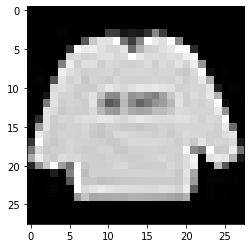

In [8]:
# displaying image using matplotlib imshow()
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [9]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

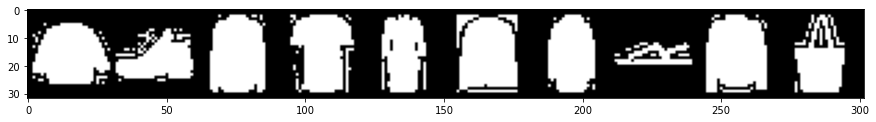

In [10]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

Intuition:
Num of conv layers:
Due to the small size of the individual data (28 x 28) px, we theorize that we don't need a very complicated network. Hence, we're looking at 2 or 3 convolutional layers.

Conv layers kernel size:
Due to the small size of the images and how they look, we think that a smaller kernel size would be better as it can then pick up on smaller details of the images. Hence, we decided on 3x3 kernel size of the convolution layer.

Pooling kernel size and stride
2x2 kernel on max pooling was decided as we didn't want to lose too much information but at the same time leave room for generalization by reducing overfitting.
Stride of 2 was chosen for the first pooling layers since the first layer is more computationally demanding due to larger matrix and same reason as above.
Stride of 1 chosen for second pooling layer to retain more information.

Batch normalization:
Used to avoid overfitting of the model and help to reduce generalization error.
Makes the training faster as well.

Activation function:
ReLU is a non-linear activation function that is idempotent (p(x) == p(p(p.......(x).......)) and hence doesnt suffer from the vanishing gradient problem.
It is also easy to compute.

Dropout:
Apply a regularization technique to preven overfitting of the model.
We plan to use a value between 0.2 to 0.3 as too low of a probability has minimal effect and a value too high will affect the learning of the model.



1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> Max Pooling layer -> Second conv layer -> second max pooling layer -> Fullyconnected layers -> output

28 * 28 * 3      --> 28 * 28 * 32      --> 14 * 14 * 32      --> 12 * 12 * 64              --> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [36]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [12]:
def train(model, error, optimizer, curr_train_loader):  
  model.train()

  running_loss=0
  correct=0
  
  for images, labels in curr_train_loader:
    # Transfering images and labels to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = error(outputs, labels)
    
    # Initializing a gradient as 0 so there is no mixing of gradient among the batches
    optimizer.zero_grad()
    
    #Propagating the error backward
    loss.backward()
    
    # Optimizing the parameters
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    
    predicted = outputs.argmax(axis=1)
    correct += predicted.eq(labels).sum().item()
        
  return running_loss, correct

In [20]:
def validate(model, error, curr_val_loader):
  model.eval()
 
  running_loss=0
  correct=0
 
  with torch.no_grad():
    for images, labels in curr_val_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = error(outputs, labels)

      running_loss += loss.item() * images.size(0)

      predictions = outputs.argmax(axis=1)
      correct += predictions.eq(labels).sum().item()
    
  return running_loss, correct

In [18]:
def test(model):
    test_loader = DataLoader(test_dataset, batch_size=100)

    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # initialize a list to store our predictions
        preds = []
        labels = []
        # loop over the test set
        for test_images, test_labels in test_loader:
            # send the input to the device
            test_images = test_images.to(device)
            # make the predictions and add them to the list
            pred = model(test_images)
            preds.extend(pred.argmax(axis=1).cpu().numpy())
            labels.extend(test_labels.cpu())
    # generate a classification report
    result = classification_report(np.array(labels),
        np.array(preds), target_names=output_mapping_list)
    result_dict = classification_report(np.array(labels),
        np.array(preds), target_names=output_mapping_list, output_dict=True)
    return result, result_dict

In [37]:
epochs=30

batch_size = 100
k = 5

splits = KFold(n_splits=k, shuffle=True, random_state=SEED)

folds = {}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    validate_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    validate_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=validate_sampler)
        
    model = FashionCNN()
    model.to(device)

    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    error = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'validation_loss': [],'train_acc':[],'validation_acc':[], 'report': None, 'report_dict': None}

    for epoch in range(epochs):
        train_loss, train_correct=train(model, error, optimizer,train_loader)
        valid_loss, valid_correct=validate(model, error, validate_loader)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        validation_loss = valid_loss / len(validate_loader.sampler)
        validation_acc = valid_correct / len(validate_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             train_loss,
                                                                                                             validation_loss,
                                                                                                             train_acc,
                                                                                                             validation_acc))
        history['train_loss'].append(train_loss)
        history['validation_loss'].append(validation_loss)
        history['train_acc'].append(train_acc)
        history['validation_acc'].append(validation_acc)
    
    test_result, test_result_dict = test(model)
    history['report'] = test_result
    history['report_dict'] = test_result_dict

    folds['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/30 AVG Training Loss:0.495 AVG Validation Loss:0.342 AVG Training Acc 82.49 % AVG Validation Acc 87.55 %
Epoch:2/30 AVG Training Loss:0.336 AVG Validation Loss:0.307 AVG Training Acc 88.05 % AVG Validation Acc 88.97 %
Epoch:3/30 AVG Training Loss:0.287 AVG Validation Loss:0.343 AVG Training Acc 89.81 % AVG Validation Acc 88.14 %
Epoch:4/30 AVG Training Loss:0.260 AVG Validation Loss:0.261 AVG Training Acc 90.64 % AVG Validation Acc 90.83 %
Epoch:5/30 AVG Training Loss:0.242 AVG Validation Loss:0.269 AVG Training Acc 91.33 % AVG Validation Acc 90.20 %
Epoch:6/30 AVG Training Loss:0.220 AVG Validation Loss:0.275 AVG Training Acc 92.09 % AVG Validation Acc 90.12 %
Epoch:7/30 AVG Training Loss:0.210 AVG Validation Loss:0.248 AVG Training Acc 92.42 % AVG Validation Acc 91.28 %
Epoch:8/30 AVG Training Loss:0.191 AVG Validation Loss:0.248 AVG Training Acc 93.08 % AVG Validation Acc 91.66 %
Epoch:9/30 AVG Training Loss:0.179 AVG Validation Loss:0.265 AVG Training Acc 93.50 % AVG

In [31]:
validation_loss_list, train_loss_list, validation_acc_list, train_acc_list, weighted_avg_f1_list, final_test_acc =[],[],[],[],[],[]
k = 5
for f in range(1,k+1):
    train_loss_list.append(np.mean(folds['fold{}'.format(f)]['train_loss']))
    validation_loss_list.append(np.mean(folds['fold{}'.format(f)]['validation_loss']))

    train_acc_list.append(np.mean(folds['fold{}'.format(f)]['train_acc']))
    validation_acc_list.append(np.mean(folds['fold{}'.format(f)]['validation_acc']))
    
    report = folds['fold{}'.format(f)]['report']
    print(report)
    report_dict = folds['fold{}'.format(f)]['report_dict']
    test_accuracy = report_dict['accuracy']
    final_test_acc.append(test_accuracy)
    weighted_avg_metrics = report_dict['weighted avg']
    wa_f1 = weighted_avg_metrics['f1-score']
    weighted_avg_f1_list.append(wa_f1)

best_f1, best_acc = weighted_avg_f1_list.index(max(weighted_avg_f1_list)) + 1 , final_test_acc.index(max(final_test_acc)) + 1

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.5f} \t Average Validation Loss: {:.5f} \t Average Training Acc: {:.5f} \t Average Validation Acc: {:.5f} \t Average Weighted Average F1: {:.5f}".format(np.mean(train_loss_list),np.mean(validation_loss_list),np.mean(train_acc_list),np.mean(validation_acc_list), np.mean(weighted_avg_f1_list)))
print("Best performing fold in terms of f1: {}\nTraining Loss: {:.5f} \t Validation Loss: {:.5f} \t Training Acc: {:.5f} \t Validation Acc: {:.5f} \t Weighted Average F1: {:.5f} \t Final_test_accuracy: {:.5f}".format(best_f1, train_loss_list[best_f1-1], validation_loss_list[best_f1-1], train_acc_list[best_f1-1], validation_acc_list[best_f1-1], weighted_avg_f1_list[best_f1-1], final_test_acc[best_f1-1]))
# print("Best performing fold in terms of accuracy: {}\nTraining Loss: {:.5f} \t Validation Loss: {:.5f} \t Training Acc: {:.5f} \t Validation Acc: {:.5f} \t Weighted Average F1: {:.5f} \t Final_test_accuracy: {:.5f}".format(best_acc, train_loss_list[best_acc-1], validation_loss_list[best_acc-1], train_acc_list[best_acc-1], validation_acc_list[best_acc-1], weighted_avg_f1_list[best_acc-1], final_test_acc[best_acc-1]))          

              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.83      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.89      0.83      0.86      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.88      0.88      0.88      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.71      0.81      0.76      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

              precision    recall  f1-score   support

 T-shirt/Top       0.86      0.82      0.84      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.91      0.79      0.84      1000
       Dress       0.90 

https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f

In [32]:
import os

if not os.path.exists('./diagrams'):
    os.makedirs('./diagrams')

best_result = folds['fold{}'.format(best_f1)]
t_l = best_result['train_loss']
t_a = best_result['train_acc']
v_l = best_result['validation_loss']
v_a = best_result['validation_acc']

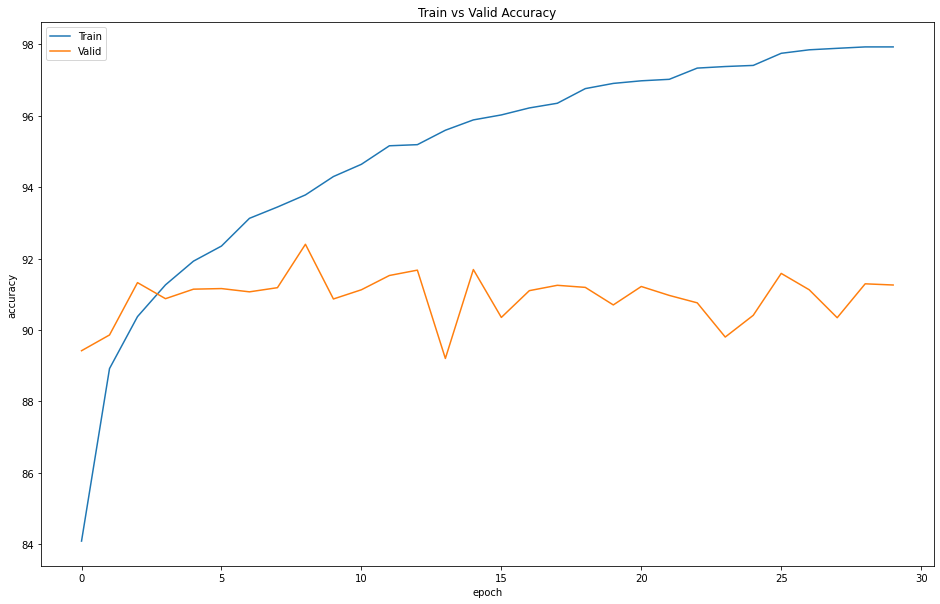

In [34]:
plt.figure(figsize=(16,10))

plt.plot(t_a)
plt.plot(v_a)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.savefig('./diagrams/cNN_Train_vs_Valid_Acc.png')

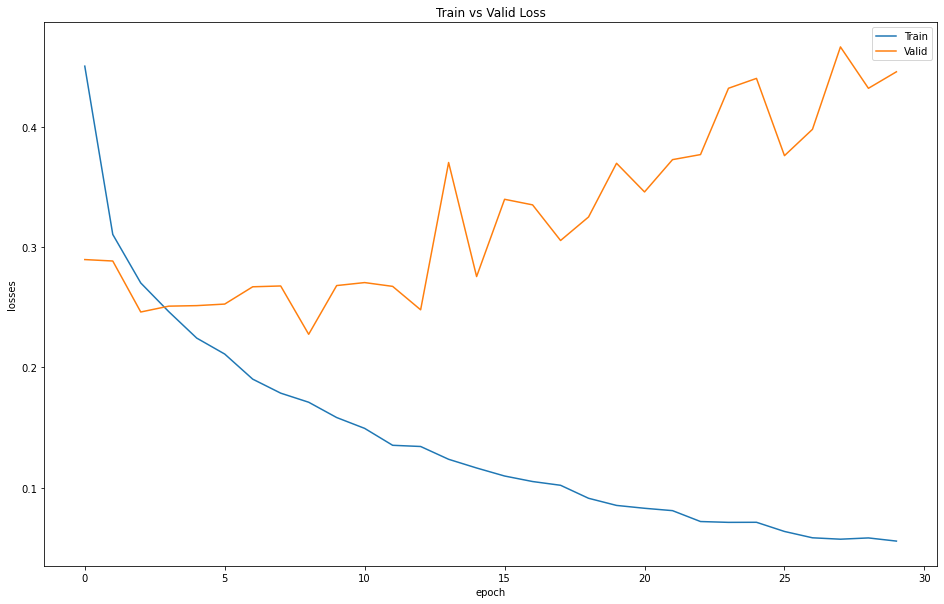

In [35]:
plt.figure(figsize=(16,10))

plt.plot(t_l)
plt.plot(v_l)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.savefig('./diagrams/cNN_Train_vs_Valid_loss.png')

From the graph we can see a downward trend of loss vs epoch. Perhaps a reason for the spikes in loss could be just due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

In [23]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 86.90%
Accuracy of Trouser: 99.60%
Accuracy of Pullover: 87.90%
Accuracy of Dress: 89.40%
Accuracy of Coat: 85.00%
Accuracy of Sandal: 96.80%
Accuracy of Shirt: 81.40%
Accuracy of Sneaker: 96.20%
Accuracy of Bag: 98.00%
Accuracy of Ankle Boot: 97.60%


In [57]:
# https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [65]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [67]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


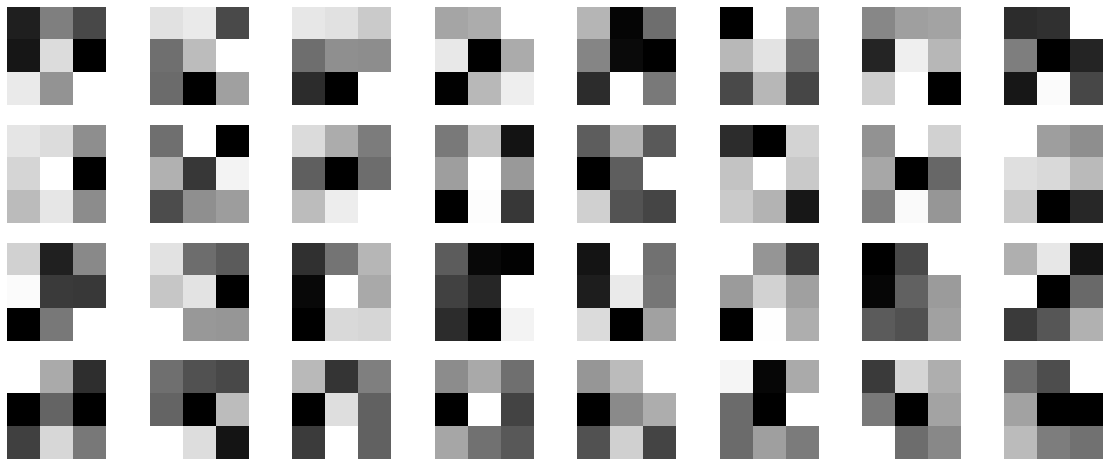

In [106]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter1.png')
plt.show()

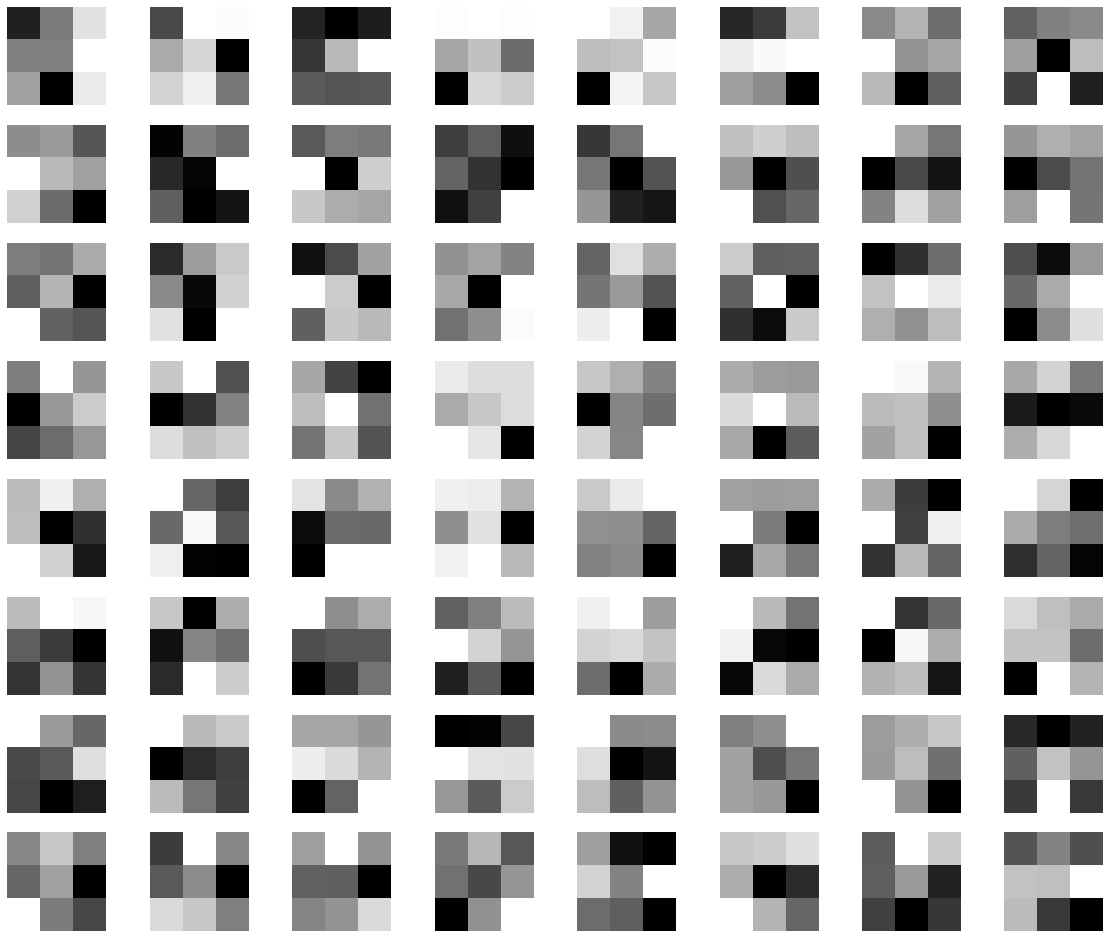

In [104]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter2.png')
plt.show()

In [97]:
print(model_weights[0].cpu())

tensor([[[[-0.3243,  0.0057, -0.1834],
          [-0.3555,  0.3243, -0.4326],
          [ 0.3751,  0.0794,  0.4477]]],


        [[[ 0.2042,  0.2393, -0.3902],
          [-0.2416,  0.0586,  0.3219],
          [-0.2565, -0.6752, -0.0495]]],


        [[[ 0.2994,  0.2793,  0.1979],
          [-0.1283, -0.0114, -0.0174],
          [-0.3594, -0.5176,  0.3863]]],


        [[[ 0.0603,  0.0814,  0.3541],
          [ 0.2769, -0.4807,  0.0777],
          [-0.4764,  0.1210,  0.2976]]],


        [[[ 0.2864, -0.3447,  0.0312],
          [ 0.1136, -0.3285, -0.3658],
          [-0.2023,  0.5523,  0.0683]]],


        [[[-0.5126,  0.5142,  0.1148],
          [ 0.2278,  0.3988, -0.0409],
          [-0.2172,  0.2252, -0.2283]]],


        [[[-0.0609,  0.0271,  0.0442],
          [-0.4212,  0.3240,  0.1164],
          [ 0.2036,  0.3851, -0.5612]]],


        [[[-0.2632, -0.2463,  0.5217],
          [ 0.0419, -0.4285, -0.2895],
          [-0.3395,  0.5035, -0.1641]]],


        [[[ 0.2399,  0.2051, -0.

In [ ]:
plt.imsave('./diagrams/pullover.png', image.squeeze(), cmap="gray")

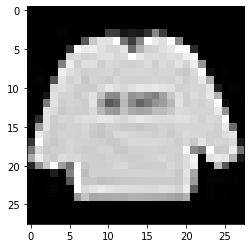

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [89]:
import cv2 as cv

# read and visualize an image
img = cv.imread(f"./diagrams/pullover.png")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [91]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [94]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./diagrams/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([32, 28, 28])
Saving layer 0 feature maps...
torch.Size([64, 26, 26])
Saving layer 1 feature maps...
